In [ ]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.8 MB/s eta 0:00:00


In [ ]:
!pip install transformers scipy ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install "ipywidgets>=7,<8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.0 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image, ImageFont, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import LMSDiscreteScheduler, UNet2DConditionModel, PNDMScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = "cuda"

output.enable_custom_widget_manager
notebook_login()

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision= "fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
)

pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

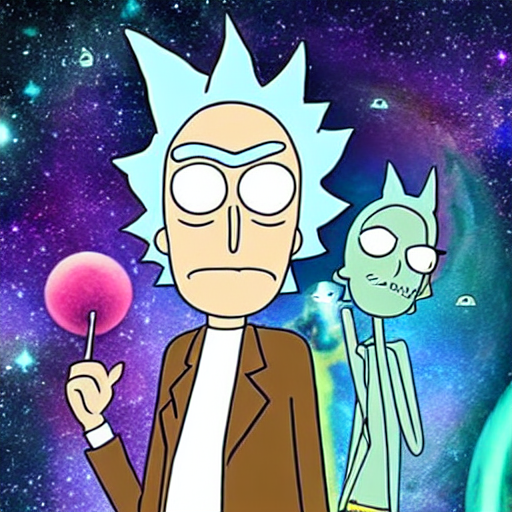

In [ ]:
prompt = "Rick and Morty in space"

with autocast(device):
    image = pipe(prompt).images[0]

image

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


  0%|          | 0/50 [00:00<?, ?it/s]

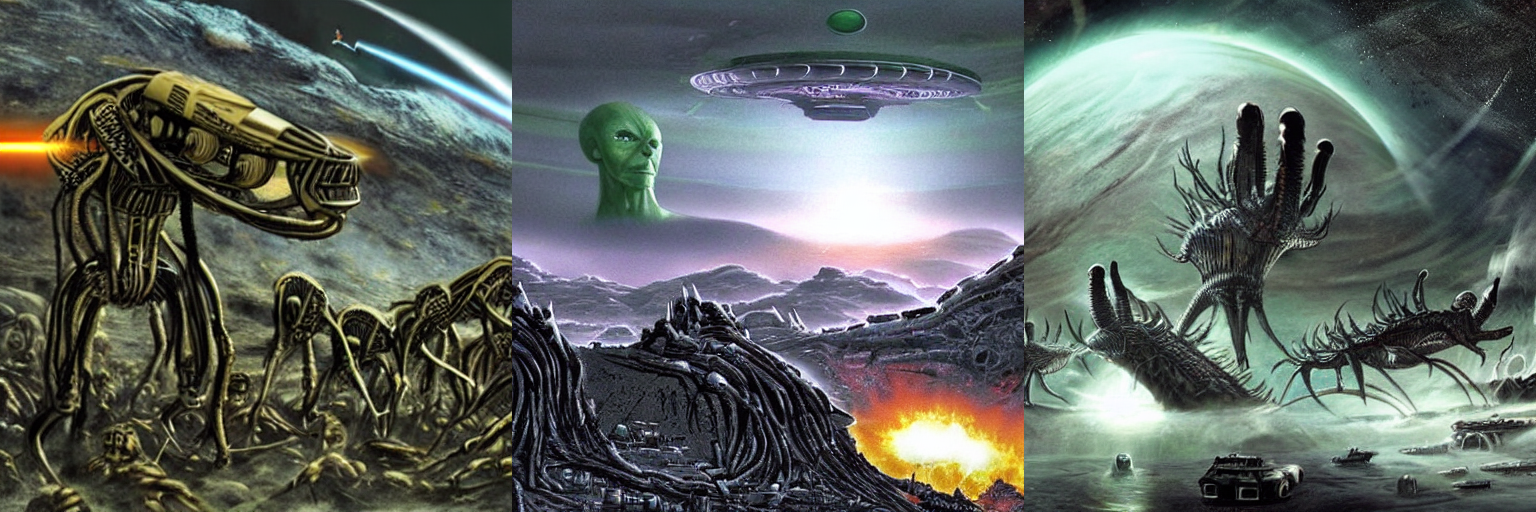

In [ ]:
bn_images = 3
prompts = ['alien armageddon on Earth in the year 2544'] * n_images

with autocast(device):
    images = pipe(prompts).images

grid = image_grid(images, rows=1, cols=3)
grid

In [ ]:
# Load variational auto encoder model - to decode latents into images
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token= True
)
vae = vae.to(device)

# Load tokenizer
tok = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
txt_enc = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
txt_enc = txt_enc.to(device)

# Load UNET model - to generate latents
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token= True
)
unet = unet.to(device)

# Create scheduler - for inference
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000
)


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
def get_text_embeddings(prompts):
  # Tokenze text to obtain embeddings
  text_input = tok(
      prompts,
      padding="max_length", max_length=tok.model_max_length,
      truncation=True, return_tensors="pt")
  with torch.no_grad():
    text_embeddings = txt_enc(text_input.input_ids.to(device))[0]

  # Same for Uncond inputs
  uncond_input = tok(
      [""] * len(prompts),
      padding="max_length", max_length=tok.model_max_length,
      truncation=True, return_tensors="pt")
  with torch.no_grad():
    uncond_embeddings = txt_enc(uncond_input.input_ids.to(device))[0]

  # Concat for final embeds
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  # Return final embeddings
  return text_embeddings

test_embeddings = get_text_embeddings(['Cute cat driving a bike'])
print(test_embeddings)
print(test_embeddings.shape)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.4771, -0.4680,  0.0514,  ..., -0.1052, -0.4885,  0.0188],
         [-0.2934,  1.0472, -0.3622,  ..., -2.6603, -0.0288, -0.5907],
         ...,
         [-0.4822,  0.1415, -0.3566,  ..., -1.0065,  0.6056,  0.0552],
         [-0.4828,  0.1424, -0.3380,  ..., -1.0138,  0.6045,  0.0565],
         [-0.4620,  0.2071, -0.3134,  ..., -0.9840,  0.6597, -0.0388]]],
       device='cuda:0')
torch.Size([2, 77, 768])


In [ ]:
# Generate latents
def gen_latents(text_embeddings, height=512, width= 512, num_inference_steps= 50, guidance_scale= 8, latents= None):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, height // 8, width // 8))
  latents = latents.to(device)

  # Create scheduler
  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  with autocast(device):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand latents when performing classifier free guidance
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # Backprop prev samples
      latents = scheduler.step(noise_pred, t, latents)["prev_sample"]

  return latents

test_latents = gen_latents(test_embeddings)
print(test_latents)
print(test_latents.shape)

<ipython-input-187-61ea54513880>:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, height // 8, width // 8))


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:372: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(


tensor([[[[-1.5065, -0.2697, -0.3849,  ..., -0.8509, -0.1682, -1.2403],
          [-0.2490, -1.9591, -1.3730,  ..., -1.0140, -0.6824, -0.7770],
          [-0.9914, -0.0389,  0.1292,  ..., -0.8414, -0.9094,  0.2658],
          ...,
          [ 0.8324,  0.4153,  0.1141,  ...,  0.0176, -0.4228,  0.5599],
          [ 0.1468,  0.2875,  0.8160,  ..., -0.8402,  1.2775, -0.1478],
          [ 0.6174,  0.2445,  0.6145,  ...,  0.3328,  0.5177,  0.6520]],

         [[-0.8091,  0.7239, -0.9925,  ...,  1.0208,  0.0559, -0.6988],
          [-0.1503, -1.5866, -0.9556,  ..., -0.6037, -0.3402,  0.1440],
          [-0.6095, -0.3303, -2.4174,  ..., -0.6356, -0.6289,  0.5455],
          ...,
          [-0.2530, -0.4258,  0.1480,  ...,  1.4285,  2.4049,  1.6642],
          [-0.5002, -0.2404,  0.9290,  ...,  0.3929,  1.0656,  1.0669],
          [ 0.6921, -0.2516, -0.2038,  ...,  1.6343,  0.9331,  1.3007]],

         [[ 0.2306,  1.2071,  0.8511,  ...,  0.8943,  0.3906,  0.3619],
          [ 1.9785, -0.4873,  

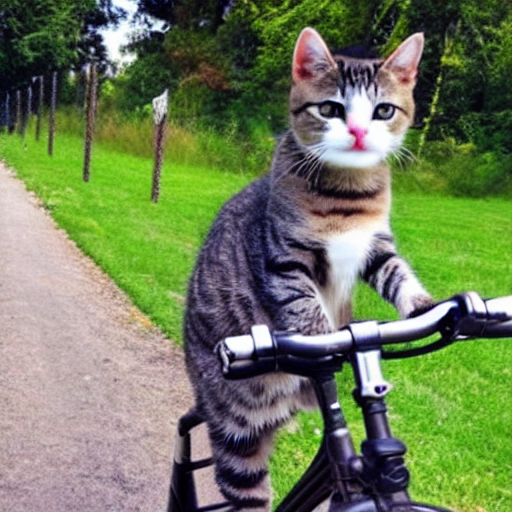

In [ ]:
def decode_img_latents(latents):
    with torch.no_grad():
      latents = 1/0.18215 * latents
      # Assuming VAE is your decoder model
      decoder_output = vae.decode(latents)

      # Access the tensor within DecoderOutput
      decoded_images = decoder_output.sample

    decoded_images = (decoded_images / 2 + 0.5).clamp(0, 1)
    decoded_images = decoded_images.detach().cpu().permute(0, 2, 3, 1).numpy()
    decoded_images = (decoded_images * 255).round().astype('uint8')

    # Convert numpy array to PIL images
    pil_images = [Image.fromarray(img) for img in decoded_images]

    return pil_images

# Example usage:
imgs = decode_img_latents(test_latents)
imgs[0]

In [ ]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeddings(prompts)

  # Text embeds -> img latents
  latents = gen_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)

  # Img latents -> imgs
  imgs = decode_img_latents(latents)

  return imgs

<ipython-input-110-61ea54513880>:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, height // 8, width // 8))


0it [00:00, ?it/s]

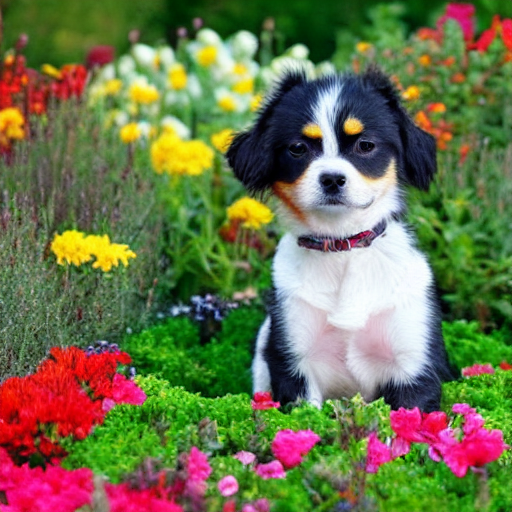

In [ ]:
prompt_to_img('Cute dog on a flower bed', 512, 512, 20)[0]

# Making a Video

In [230]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  latent_hist = [latents]
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents)['prev_sample']
      latent_hist.append(latents)

  if not return_all_latents:
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents

def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                  batch_size=2):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeddings(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
      return_all_latents=return_all_latents)

  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

In [231]:
prompt = 'Van Gogh style Rick and Morty digital art'
video_frames = prompt_to_img(
    prompt, num_inference_steps=40, return_all_latents=True)

<ipython-input-230-5a221eb6e007>:5: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \


0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

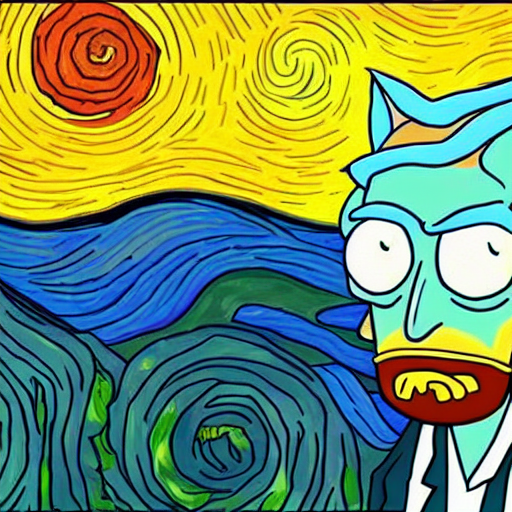

In [232]:
video_frames[-1]

In [233]:
def imgs_to_video(imgs, video_name='video.mp4', fps=15):
  video_dims = (imgs[0].width, imgs[0].height)
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')
  video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
  for img in imgs:
    tmp_img = img.copy()
    video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
  video.release()

def display_video(file_path, width=512):
  compressed_vid_path = 'comp_' + file_path
  if os.path.exists(compressed_vid_path):
    os.remove(compressed_vid_path)
  os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

  mp4 = open(compressed_vid_path, 'rb').read()
  data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
  return HTML("""
    <video width={} controls>
          <source src="{}" type="video/mp4">
    </video>
    """.format(width, data_url))

In [234]:
vid_name = prompt.replace(' ', '_') + '.mp4'
imgs_to_video(video_frames, vid_name)
display_video(vid_name)